In [3]:
import numpy as np
from functions import montecarlo, montecarlo_average
from matplotlib import pyplot as plt
import importlib

In [3]:
N = 5
w = 1
k = 1/0.129
n_th = 0.063

a = np.zeros((N, N))
for n in range(1, N):
    a[n-1, n] = np.sqrt(n)
a_dag = np.zeros((N, N))
for n in range(N-1):
    a_dag[n+1, n] = np.sqrt(n+1)

H = w * a_dag @ a

In [4]:
c_ops = []

c_ops.append(np.sqrt(k * (1 + n_th)) * a)
c_ops.append(np.sqrt(k * n_th) * a_dag)

psi0 = np.zeros(N)
psi0[1] = 1

In [5]:
times = np.linspace(0, 8, 10000)
result = montecarlo(H, c_ops, psi0, times)
N_evolution = [np.linalg.norm(a @ psi) ** 2 / np.linalg.norm(psi) ** 2 for psi in result]

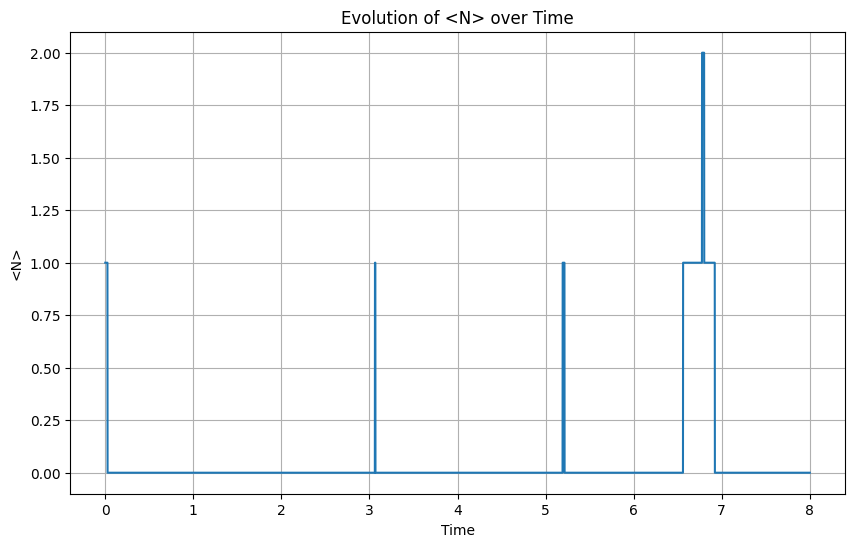

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(times, N_evolution)
plt.xlabel('Time')
plt.ylabel('<N>')
plt.title('Evolution of <N> over Time')
plt.grid(True)
plt.show()

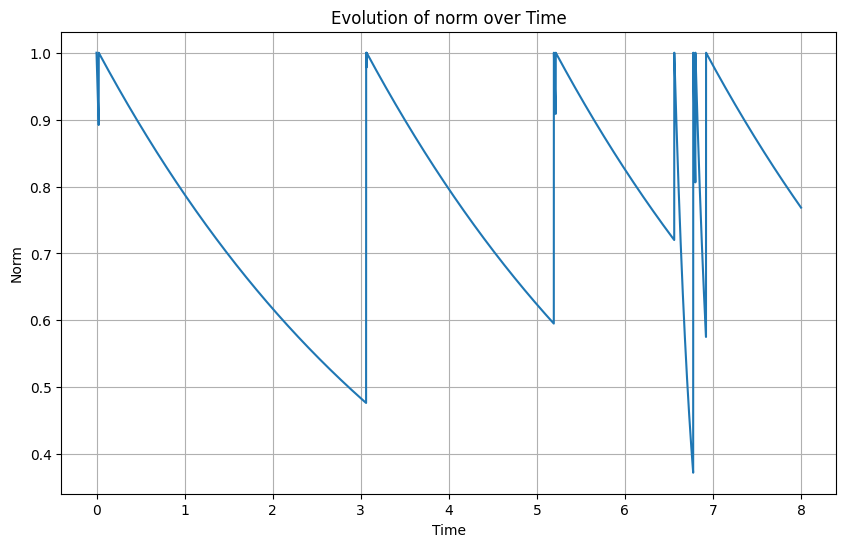

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(times, [np.linalg.norm(psi) for psi in result])
plt.xlabel("Time")
plt.ylabel("Norm")
plt.title("Evolution of norm over Time")
plt.grid(True)
plt.show()

In [7]:
times = np.linspace(0, 0.8, 1000)
result = montecarlo_average(H, c_ops, psi0, times, 200, a_dag @ a)

C:\Users\Pietro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\Pietro\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


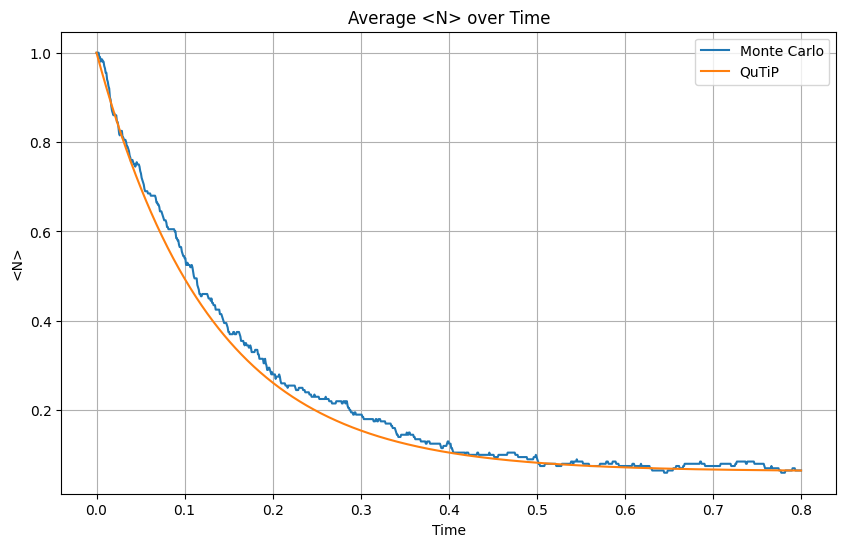

In [8]:
from qutip import mesolve, destroy, basis

aq = destroy(N)  # Destroy operator
Hq = aq.dag() * aq
c_opsq = []
c_opsq.append(np.sqrt(k * (1 + n_th)) * aq)
c_opsq.append(np.sqrt(k * n_th) * aq.dag())
psi0q = basis(N, 1)
me = mesolve(Hq, psi0q, times, c_opsq, [aq.dag() * aq])

plt.figure(figsize=(10, 6))
plt.plot(times, result)
plt.plot(times, me.expect[0])
plt.legend(['Monte Carlo', 'QuTiP'])
plt.xlabel('Time')
plt.ylabel('<N>')
plt.title('Average <N> over Time')
plt.grid(True)

# Rabi oscillations

In [3]:
hbar = 1.0545718e-34
a_rel = 3e-2  # atom relaxation time
Omega = 47e3 * 2 * np.pi  # Rabi frequency
f = 51.99e9  # driving frequency
c_rel = 220e-6  # cavity relaxation time
dephase = 0  # dephasing rate

In [4]:
# parameters for damped oscillations
N = 2  # only two fock states
wc = 1.0e-3 * 2 * np.pi  # cavity frequency
wa = wc  # atom frequency
g = 0.05*2*np.pi  # coupling strength
kappa = 0.005  # cavity dissipation rate
gamma = 0.05  # atom dissipation rate
n_th_a = 0.1  # temperature in frequency units

In [5]:
psi0 = np.kron((1, 0), (0, 1)).astype(complex)
a = np.zeros((N, N))
for n in range(1, N):
    a[n - 1, n] = np.sqrt(n)
a = np.kron(a, np.eye(2))
a_dag = np.zeros((N, N))
for n in range(N - 1):
    a_dag[n + 1, n] = np.sqrt(n + 1)
a_dag = np.kron(a_dag, np.eye(2))

sm = np.zeros((2,2))
sm[0,1] = 1
sm = np.kron(np.eye(N), sm)
sp = np.zeros((2,2))
sp[1,0] = 1
sp = np.kron(np.eye(N), sp)
sz = np.zeros((2,2))
sz[0,0] = 1
sz[1,1] = -1
sz = np.kron(np.eye(N), sz)

H = wc * a_dag @ a + wa/2 * sz + g * (a_dag @ sm + a @ sp)

In [4]:
c_op_list = []
c_op_list.append(np.sqrt(kappa * (1 + n_th_a)) * a)
c_op_list.append(np.sqrt(kappa * n_th_a) * a_dag)
c_op_list.append(np.sqrt(gamma * (1 + n_th_a)) * sm)
c_op_list.append(np.sqrt(gamma * n_th_a) * sp)

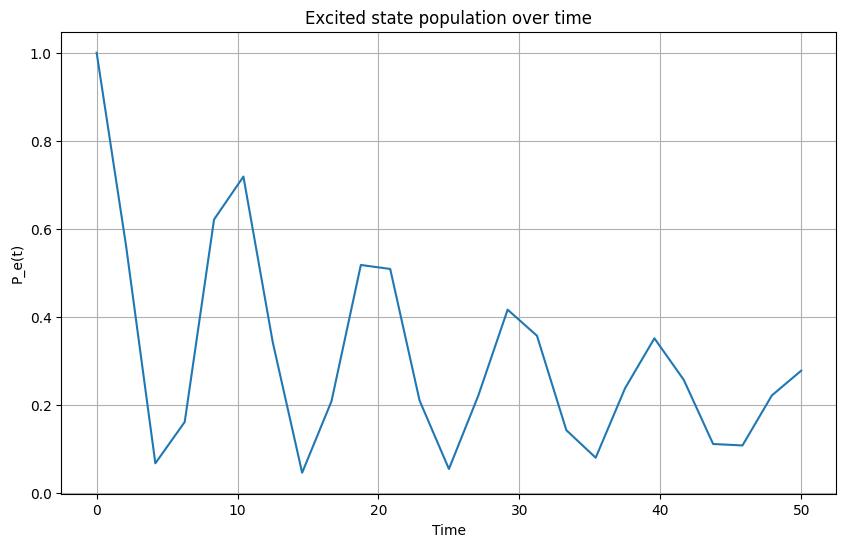

In [22]:
times = np.linspace(0, 50, 25)
result_f = montecarlo_average(H, c_op_list, psi0, times, 1000, sp @ sm)

plt.figure(figsize=(10, 6))
plt.plot(times, result_f)
plt.xlabel('Time')
plt.ylabel('P_e(t)')
plt.title('Excited state population over time')
plt.grid(True)


# ODE solver vs matrix exponential vs `mcsolve` time comparison

Time taken using zvode: 3.3003523349761963 seconds
Time taken using matrix exponential: 10.057771921157837 seconds


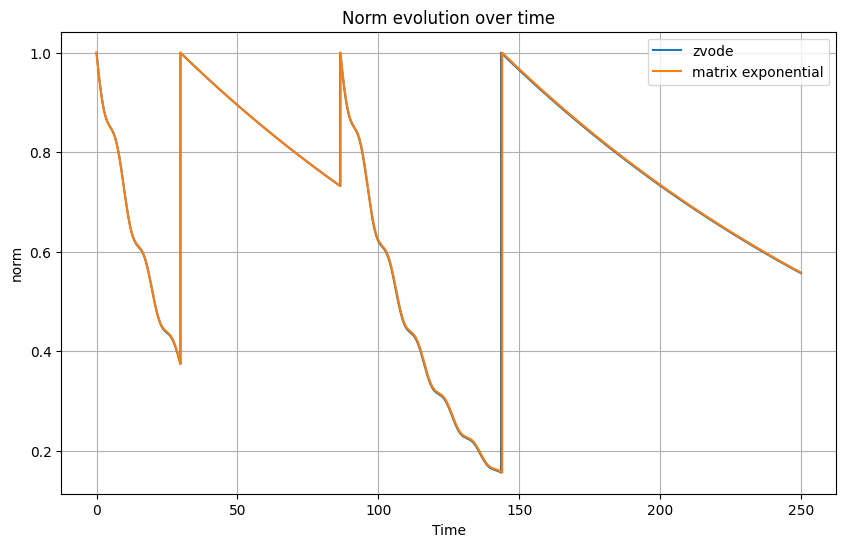

In [6]:
import functions
importlib.reload(functions)
from functions import montecarlo
import time

times = np.linspace(0, 250, 100000)


start_time = time.time()
result_ode = montecarlo(H, c_op_list, psi0, times, 42)

end_time = time.time()
print(f"Time taken using zvode: {end_time - start_time} seconds")

start_time = time.time()
result_exp = montecarlo(H, c_op_list, psi0, times, 42, False)

end_time = time.time()
print(f"Time taken using matrix exponential: {end_time - start_time} seconds")

P_evolution_ode = [np.linalg.norm(psi) ** 2 for psi in result_ode]
P_evolution_exp = [np.linalg.norm(psi) ** 2 for psi in result_exp]


plt.figure(figsize=(10, 6))

plt.plot(times, P_evolution_ode, label="zvode")
plt.plot(times, P_evolution_exp, label="matrix exponential")
plt.xlabel("Time")
plt.ylabel("norm")
plt.title("Norm evolution over time")
plt.legend()

plt.grid(True)

In [7]:
from qutip import tensor, basis, destroy, qeye, sigmaz, mcsolve, mesolve

psi0q = tensor(basis(N, 0), basis(2, 0))  # for damped we start with Fock state
# collapse operators
aq = tensor(destroy(N), qeye(2))
smq = tensor(qeye(N), destroy(2).dag())
szq = tensor(qeye(N), sigmaz())

# Hamiltonian

Hq = wc * aq.dag() * aq + wa / 2 * szq + g * (aq.dag() * smq + aq * smq.dag())

c_op_listq = []

# Photon annihilation
rate = kappa * (1 + n_th_a)
c_op_listq.append(np.sqrt(rate) * aq)

# Photon creation
rate = kappa * n_th_a
c_op_listq.append(np.sqrt(rate) * aq.dag())

# Atom annihilation
rate = gamma * (1 + n_th_a)
c_op_listq.append(np.sqrt(rate) * smq)

# Atom creation
rate = gamma * n_th_a
c_op_listq.append(np.sqrt(rate) * smq.dag())

start_time = time.time()
output_mc = mcsolve(
    Hq,
    psi0q,
    times,
    c_op_listq,
    smq.dag() * smq,
    ntraj=1,
)
end_time = time.time()
print(f"Time taken: {end_time - start_time} seconds")

100.0%. Run time:   0.00s. Est. time left: 00:00:00:00
Total run time:   5.06s
Time taken: 5.0651936531066895 seconds


10.0%. Run time:   0.35s. Est. time left: 00:00:00:03
20.0%. Run time:   0.70s. Est. time left: 00:00:00:02
30.0%. Run time:   1.01s. Est. time left: 00:00:00:02
40.0%. Run time:   1.32s. Est. time left: 00:00:00:01
50.0%. Run time:   1.66s. Est. time left: 00:00:00:01
60.0%. Run time:   1.97s. Est. time left: 00:00:00:01
70.0%. Run time:   2.28s. Est. time left: 00:00:00:00
80.0%. Run time:   2.60s. Est. time left: 00:00:00:00
90.0%. Run time:   2.92s. Est. time left: 00:00:00:00
100.0%. Run time:   3.22s. Est. time left: 00:00:00:00
Total run time:   3.23s


Text(0.5, 1.0, 'Vacuum Rabi oscillations at T=0.1')

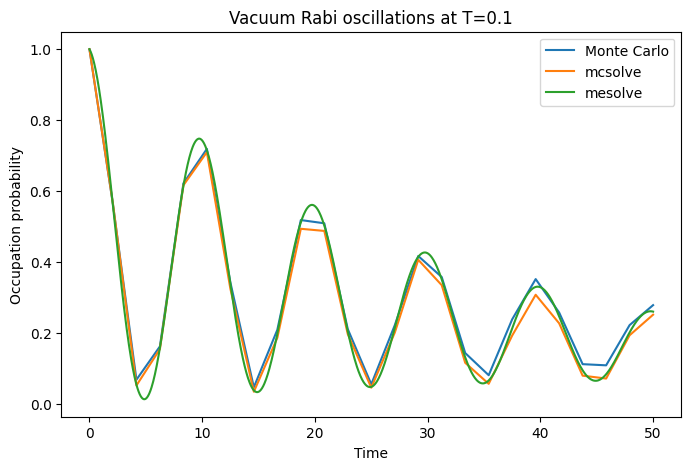

In [23]:
from qutip import tensor, basis, destroy, qeye, sigmaz, mcsolve, mesolve

psi0q = tensor(basis(N, 0), basis(2, 0))  # for damped we start with Fock state
# collapse operators
aq = tensor(destroy(N), qeye(2))
smq = tensor(qeye(N), destroy(2).dag())
szq = tensor(qeye(N), sigmaz())

# Hamiltonian

Hq = wc * aq.dag() * aq + wa / 2 * szq + g * (aq.dag() * smq + aq * smq.dag())

c_op_listq = []

# Photon annihilation
rate = kappa * (1 + n_th_a)
c_op_listq.append(np.sqrt(rate) * aq)

# Photon creation
rate = kappa * n_th_a
c_op_listq.append(np.sqrt(rate) * aq.dag())

# Atom annihilation
rate = gamma * (1 + n_th_a)
c_op_listq.append(np.sqrt(rate) * smq)

# Atom creation
rate = gamma * n_th_a
c_op_listq.append(np.sqrt(rate) * smq.dag())

times_mc = np.linspace(0, 50, 25)
times_me = np.linspace(0, 50, 1000)

output_mc = mcsolve(
    Hq,
    psi0q,
    times_mc,
    c_op_listq,
    smq.dag() * smq,
    ntraj=1000,
)
output_me = mesolve(Hq, psi0q, times_me, c_op_listq, [smq.dag() * smq])

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(times, result_f)
ax.plot(times_mc, output_mc.expect[0])
ax.plot(times_me, output_me.expect[0])
ax.legend(["Monte Carlo", "mcsolve", "mesolve"])
ax.set_xlabel("Time")
ax.set_ylabel("Occupation probability")
ax.set_title("Vacuum Rabi oscillations at T={}".format(n_th_a))